In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [2]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

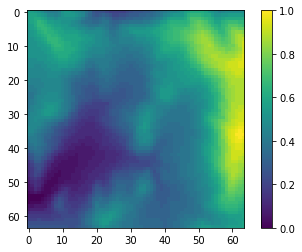

In [5]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[42600].view(64, 64))
plt.colorbar(p)
plt.show()

In [6]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
def cnn(in_n, out_n):
    return nn.Conv2d(in_n, out_n, kernel_size=3, padding=1)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn_1 = cnn(1, 32)
        self.cnn_2 = cnn(32, 64)
        self.cnn_3 = cnn(64, 128)
        self.cnn_4 = cnn(128, 256)
        self.cnn_5 = cnn(256, 1)
        
    def forward(self, data):
        x = self.cnn_1(data)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = self.cnn_2(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = self.cnn_3(x)
        x = F.leaky_relu(F.max_pool2d(x, 2))
        
        x = self.cnn_4(x)
        x = F.leaky_relu(F.max_pool2d(x, 8))
        
        x = torch.sigmoid(self.cnn_5(x))
        return x

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear_1 = nn.Linear(64, 4096)
        
        self.cnn_1 = cnn(256, 128)
        self.cnn_2 = cnn(128, 64)
        self.cnn_3 = cnn(64, 32)
        self.cnn_4 = cnn(32, 1)
        
    def forward(self, data):
        x = F.leaky_relu(self.linear_1(data))
        x = x.view(x.size(0), 256, 4, 4)
        
        x = F.interpolate(x, 8)
        x = F.leaky_relu(self.cnn_1(x))
        
        x = F.interpolate(x, 16)
        x = F.leaky_relu(self.cnn_2(x))
        
        x = F.interpolate(x, 32)
        x = F.leaky_relu(self.cnn_3(x))
        
        x = F.interpolate(x, 64)
        x = torch.sigmoid(self.cnn_4(x))
        return x

In [10]:
disc = Discriminator().cuda()
gen = Generator().cuda()

In [11]:
import torch.optim as optim

disc_optimizer = optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))

In [12]:
disc.train()
gen.train()

epochs = 100

loss_func = nn.BCELoss()

for epoch in range(epochs):
    for i, data in enumerate(dataloader):
        data = data.cuda()
        data_size = data.shape[0]
        
        # Train discriminator
        
        # real data
        disc.zero_grad()
        label = (torch.ones(data_size) * 0.9).cuda()
        out = disc(data).reshape(-1)
        disc_loss_real = loss_func(out, label)
        
        # fake data
        rand_vec = torch.randn(data_size, 64).cuda()
        fake_data = gen(rand_vec)
        label = (torch.ones(data_size) * 0.1).cuda()
        out = disc(fake_data.detach()).reshape(-1)
        disc_loss_fake = loss_func(out, label)
        
        disc_loss = disc_loss_real + disc_loss_fake
        disc_loss.backward()
        disc_optimizer.step()
        
        # Train generator
        gen.zero_grad()
        label = torch.ones(data_size).cuda()
        out = disc(fake_data).reshape(-1)
        gen_loss = loss_func(out, label)
        gen_loss.backward()
        gen_optimizer.step()
        
        if i % 100 == 0:
            msg = "epoch[{}/{}], disc_loss={:.3f}, gen_loss={:.3f}".format(epoch + 1, epochs, 
                    disc_loss.item(), gen_loss.item())
            print(msg)

epoch[1/100], disc_loss=1.388, gen_loss=0.664
epoch[1/100], disc_loss=1.314, gen_loss=0.832
epoch[1/100], disc_loss=1.265, gen_loss=1.038
epoch[1/100], disc_loss=1.376, gen_loss=0.740
epoch[1/100], disc_loss=1.318, gen_loss=0.832
epoch[1/100], disc_loss=1.375, gen_loss=0.701
epoch[2/100], disc_loss=1.379, gen_loss=0.741
epoch[2/100], disc_loss=1.424, gen_loss=0.877
epoch[2/100], disc_loss=1.378, gen_loss=0.703
epoch[2/100], disc_loss=1.354, gen_loss=0.735
epoch[2/100], disc_loss=1.311, gen_loss=0.814
epoch[2/100], disc_loss=1.338, gen_loss=0.780
epoch[3/100], disc_loss=1.309, gen_loss=0.766
epoch[3/100], disc_loss=1.291, gen_loss=0.842
epoch[3/100], disc_loss=1.308, gen_loss=0.851
epoch[3/100], disc_loss=1.225, gen_loss=1.044
epoch[3/100], disc_loss=1.295, gen_loss=1.216
epoch[3/100], disc_loss=1.229, gen_loss=0.850
epoch[4/100], disc_loss=1.263, gen_loss=0.964
epoch[4/100], disc_loss=1.298, gen_loss=0.769
epoch[4/100], disc_loss=1.225, gen_loss=1.018
epoch[4/100], disc_loss=1.224, gen

epoch[30/100], disc_loss=0.739, gen_loss=2.088
epoch[30/100], disc_loss=0.784, gen_loss=1.953
epoch[30/100], disc_loss=0.782, gen_loss=1.978
epoch[30/100], disc_loss=0.744, gen_loss=2.049
epoch[31/100], disc_loss=1.031, gen_loss=2.276
epoch[31/100], disc_loss=0.772, gen_loss=2.475
epoch[31/100], disc_loss=0.813, gen_loss=2.011
epoch[31/100], disc_loss=0.756, gen_loss=2.005
epoch[31/100], disc_loss=0.736, gen_loss=2.025
epoch[31/100], disc_loss=0.770, gen_loss=2.164
epoch[32/100], disc_loss=0.971, gen_loss=1.137
epoch[32/100], disc_loss=0.762, gen_loss=1.662
epoch[32/100], disc_loss=0.768, gen_loss=2.011
epoch[32/100], disc_loss=0.734, gen_loss=1.934
epoch[32/100], disc_loss=0.727, gen_loss=1.975
epoch[32/100], disc_loss=0.768, gen_loss=1.965
epoch[33/100], disc_loss=0.814, gen_loss=2.586
epoch[33/100], disc_loss=0.774, gen_loss=2.006
epoch[33/100], disc_loss=0.748, gen_loss=1.927
epoch[33/100], disc_loss=0.838, gen_loss=1.507
epoch[33/100], disc_loss=0.796, gen_loss=1.882
epoch[33/100]

epoch[59/100], disc_loss=0.710, gen_loss=2.175
epoch[59/100], disc_loss=0.726, gen_loss=1.865
epoch[59/100], disc_loss=0.716, gen_loss=2.092
epoch[60/100], disc_loss=0.720, gen_loss=1.997
epoch[60/100], disc_loss=0.708, gen_loss=2.036
epoch[60/100], disc_loss=0.714, gen_loss=2.168
epoch[60/100], disc_loss=0.709, gen_loss=2.232
epoch[60/100], disc_loss=0.718, gen_loss=2.107
epoch[60/100], disc_loss=0.751, gen_loss=2.102
epoch[61/100], disc_loss=0.959, gen_loss=0.342
epoch[61/100], disc_loss=0.737, gen_loss=2.266
epoch[61/100], disc_loss=0.713, gen_loss=2.138
epoch[61/100], disc_loss=0.695, gen_loss=2.207
epoch[61/100], disc_loss=0.723, gen_loss=2.134
epoch[61/100], disc_loss=0.726, gen_loss=2.542
epoch[62/100], disc_loss=0.786, gen_loss=1.566
epoch[62/100], disc_loss=0.707, gen_loss=2.399
epoch[62/100], disc_loss=0.708, gen_loss=2.063
epoch[62/100], disc_loss=0.703, gen_loss=2.515
epoch[62/100], disc_loss=0.697, gen_loss=2.257
epoch[62/100], disc_loss=0.744, gen_loss=2.111
epoch[63/100]

epoch[88/100], disc_loss=0.688, gen_loss=2.274
epoch[88/100], disc_loss=0.690, gen_loss=2.283
epoch[89/100], disc_loss=0.778, gen_loss=1.362
epoch[89/100], disc_loss=0.694, gen_loss=2.334
epoch[89/100], disc_loss=0.691, gen_loss=2.375
epoch[89/100], disc_loss=0.699, gen_loss=2.326
epoch[89/100], disc_loss=0.688, gen_loss=2.212
epoch[89/100], disc_loss=0.733, gen_loss=2.266
epoch[90/100], disc_loss=0.710, gen_loss=2.338
epoch[90/100], disc_loss=0.689, gen_loss=2.388
epoch[90/100], disc_loss=0.685, gen_loss=2.162
epoch[90/100], disc_loss=0.685, gen_loss=2.313
epoch[90/100], disc_loss=0.711, gen_loss=1.486
epoch[90/100], disc_loss=0.710, gen_loss=2.314
epoch[91/100], disc_loss=0.740, gen_loss=2.458
epoch[91/100], disc_loss=0.687, gen_loss=2.182
epoch[91/100], disc_loss=0.687, gen_loss=2.422
epoch[91/100], disc_loss=0.702, gen_loss=2.087
epoch[91/100], disc_loss=0.717, gen_loss=2.184
epoch[91/100], disc_loss=0.697, gen_loss=2.353
epoch[92/100], disc_loss=0.703, gen_loss=1.875
epoch[92/100]

In [18]:
torch.save(disc.state_dict(), './gan_disc_save')
torch.save(gen.state_dict(), './gan_gen_save')

In [16]:
disc.load_state_dict(torch.load('./gan_disc_save'))
gen.load_state_dict(torch.load('./gan_gen_save'))

<All keys matched successfully>

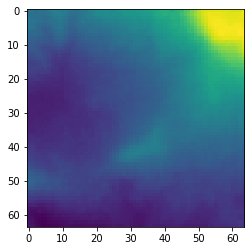

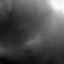

In [19]:
# Generation

code = torch.randn(1, 64)
out = gen(code.cuda())
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()
display(transforms.ToPILImage()(out.view(64, 64).cpu().detach()))

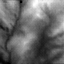

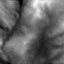

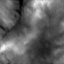

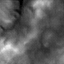

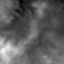

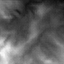

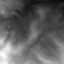

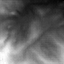

In [21]:
# Interpolation

code1 = torch.randn(1, 64)
code2 = torch.randn(1, 64)

delta = (code2 - code1) / 7

out1 = gen(code1.cuda())
display(transforms.ToPILImage()(out1.view(64, 64).cpu()))

for i in range(7):
    code1 += delta
    out = gen(code1.cuda())
    display(transforms.ToPILImage()(out.view(64, 64).cpu()))